# This is my notebook that I submitted in "Housing Prices Competition for Kaggle Learn Users". In the competition, my result was in the top 2% of all users. I used a staking of 4 models, namely Gradient Boosting, XGBoost, Light LGB, CatBoost.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv


In [2]:
train = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col=0)
test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col=0)

print(train.shape, test.shape)

(1460, 80) (1459, 79)


In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
X = pd.concat([train.drop('SalePrice', axis=1), test], axis=0)
y = train['SalePrice']

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [6]:
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [7]:
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [8]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

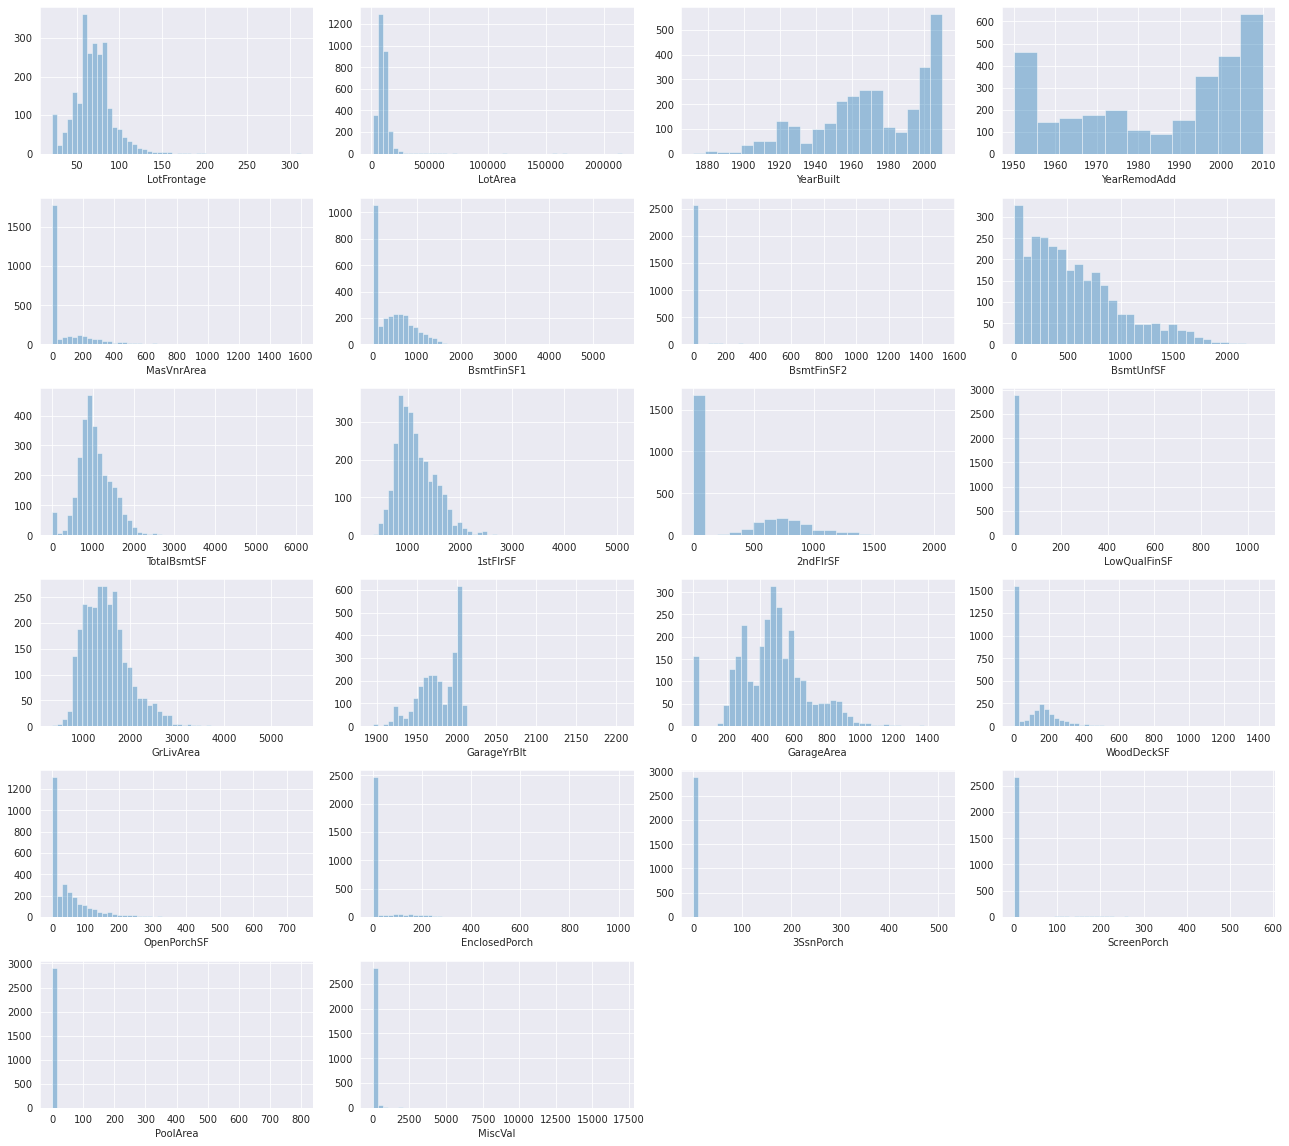

In [9]:
fig = plt.figure(figsize=(18,16))
for index, col in enumerate(cont_num_var):
    plt.subplot(6, 4, index+1)
    sns.distplot(numeric_.loc[:, col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

In [10]:
len(disc_num_var)

13

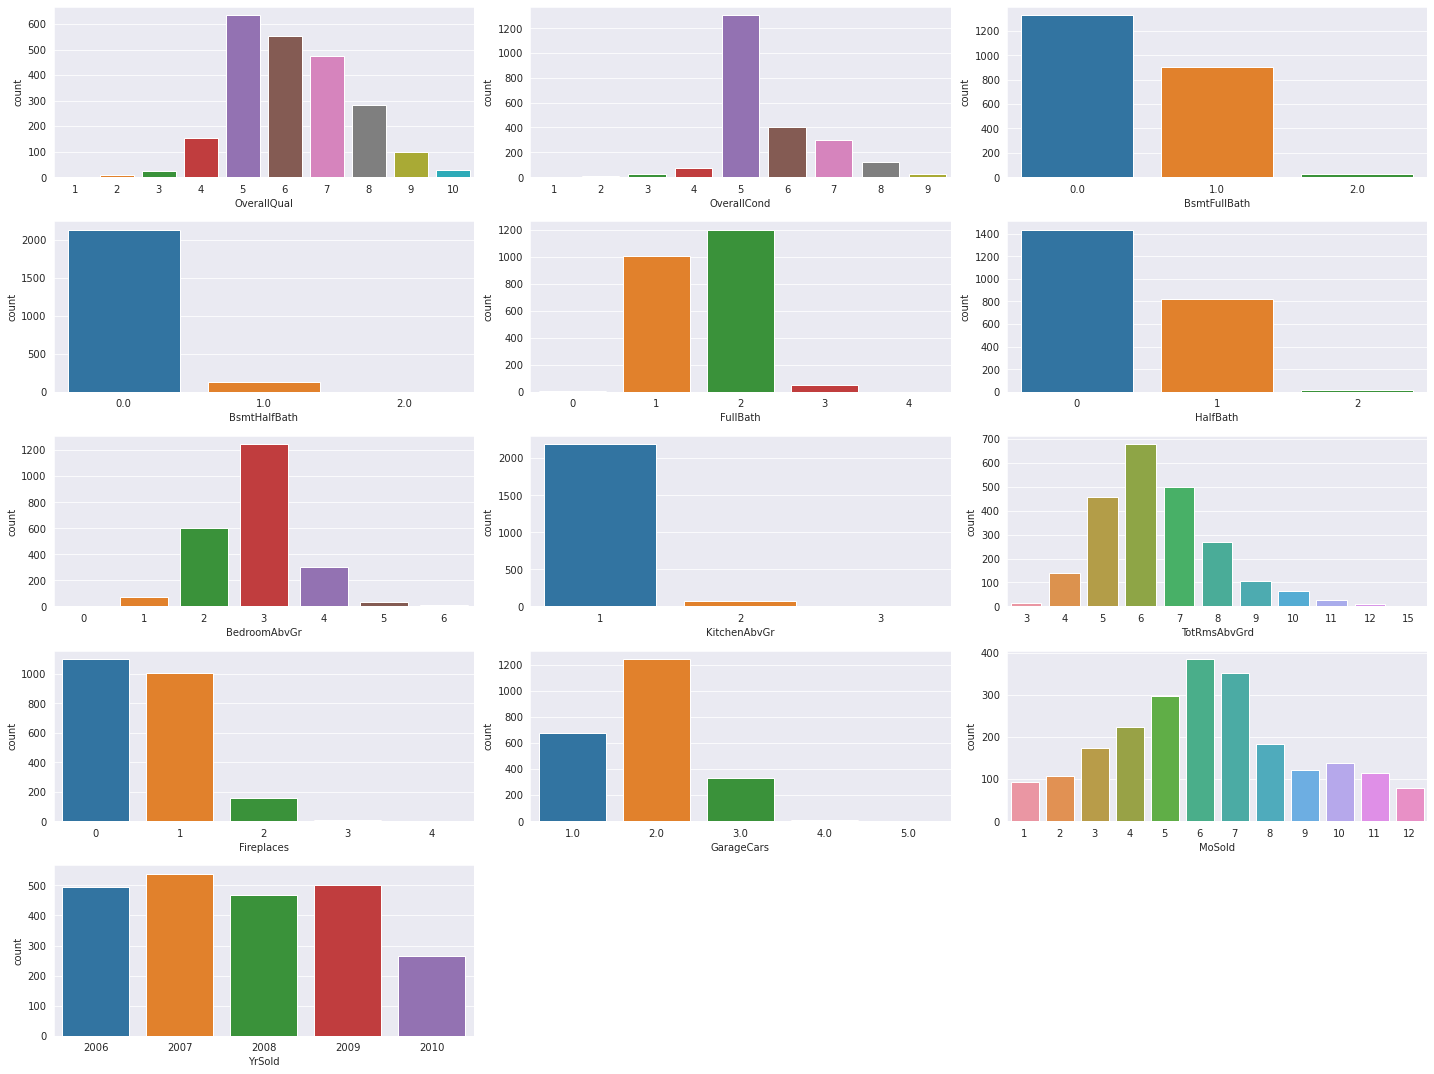

In [11]:
fig = plt.figure(figsize=(20,15))
for index, col in enumerate(disc_num_var):
    plt.subplot(5, 3, index+1)
    sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1)

Bi-Variate Analysis

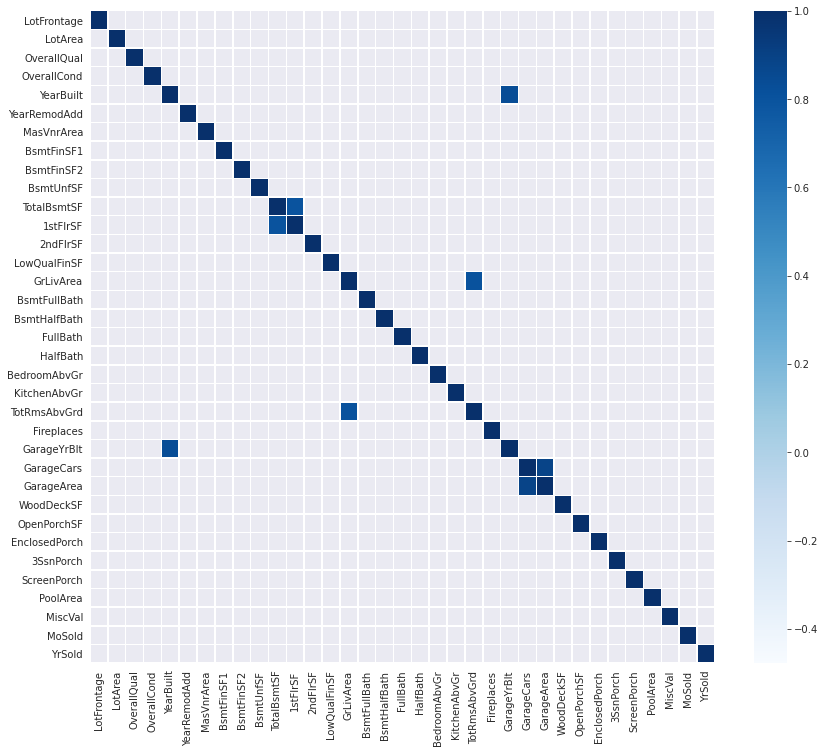

In [12]:
plt.figure(figsize=(14,12))
correlation = numeric_.corr()
sns.heatmap(correlation, mask=correlation <0.8, linewidth=0.5, cmap='Blues')

In [13]:
X.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars'], axis=1, inplace=True)

In [14]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values('SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


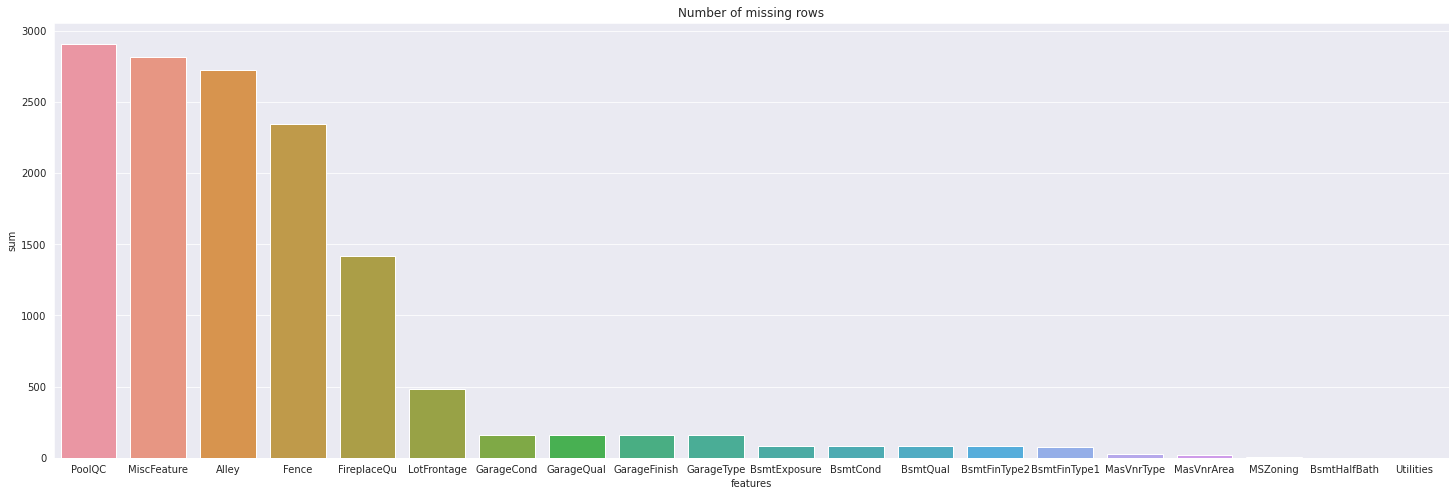

In [15]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by='sum', ascending=False).head(20).reset_index()
missing_count.columns = ['features', 'sum']
sns.barplot(x='features', y='sum', data=missing_count)

In [16]:
X.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

In [17]:
X.drop(['MoSold', 'YrSold'], axis=1, inplace=True)

In [18]:
len(missing_count)

20

In [19]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)
X = X.drop(overfit_cat, axis=1)

In [20]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

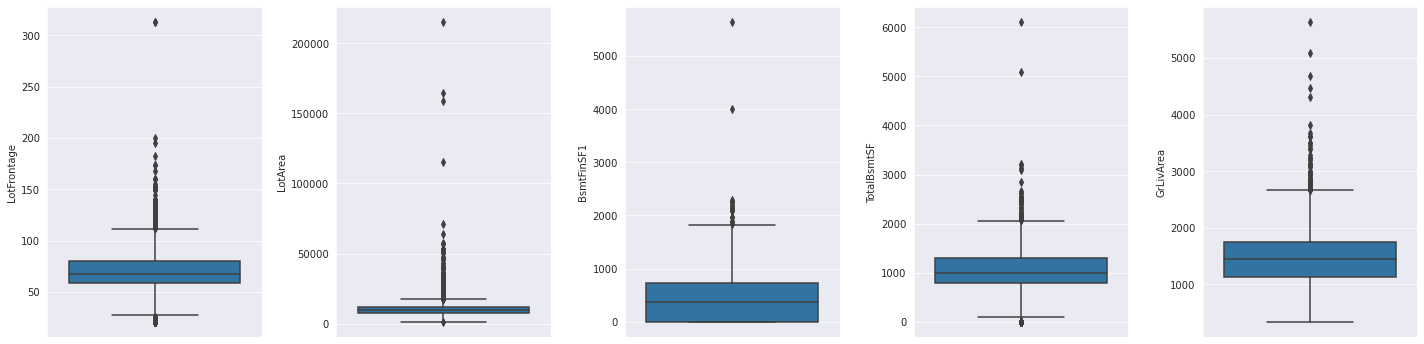

In [21]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [22]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

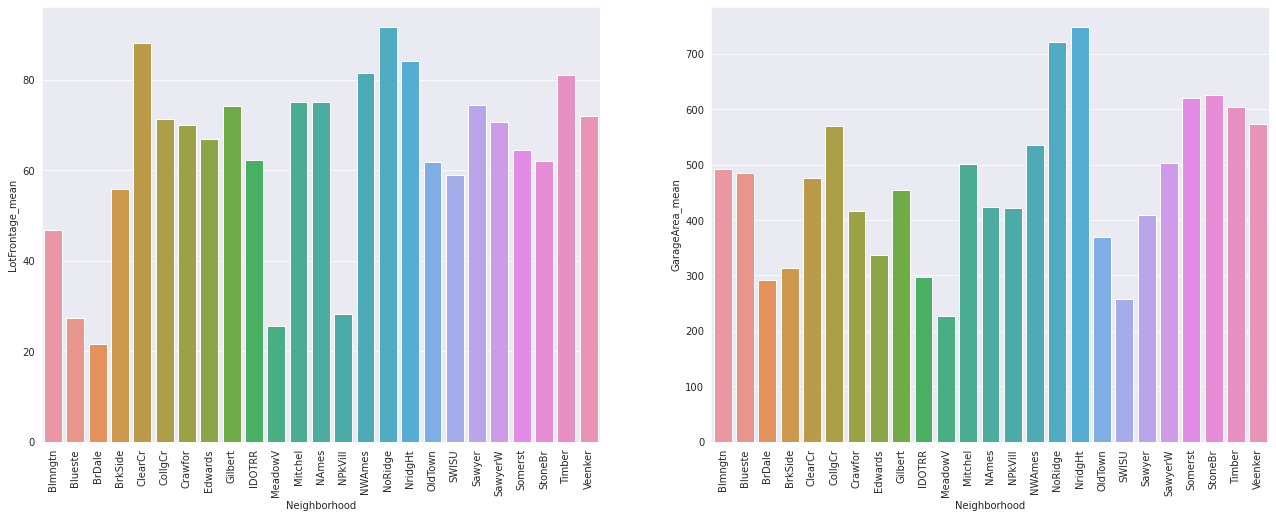

In [23]:
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [24]:
X['MSSubClass']

Id
1        60
2        20
3        60
4        70
5        60
       ... 
2915    160
2916    160
2917     20
2918     85
2919     60
Name: MSSubClass, Length: 2919, dtype: int64

In [25]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")

In [26]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

In [27]:
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont].fillna(X[cont].mean())

In [28]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

In [29]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

In [30]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

In [31]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col + '_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x>0 else 0)

In [32]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,TotalBsmtFin,TotalSF,TotalBath,TotalPorch,MasVnrArea_bin,TotalBsmtFin_bin,TotalBsmtSF_bin,2ndFlrSF_bin,WoodDeckSF_bin,TotalPorch_bin
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,706.0,1710.0,3,61,1,1,1,1,0,1
2,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,978.0,1262.0,2,0,0,1,1,0,1,0
3,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,486.0,1786.0,3,42,1,1,1,1,0,1
4,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,216.0,1512.0,1,307,0,1,1,1,0,1
5,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,655.0,2198.0,3,84,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Reg,Lvl,Inside,Gtl,MeadowV,Norm,...,0.0,1092.0,2,0,0,0,1,1,0,0
2916,160,RM,21.0,1894,Reg,Lvl,Inside,Gtl,MeadowV,Norm,...,252.0,1092.0,2,24,0,1,1,1,0,1
2917,20,RL,160.0,20000,Reg,Lvl,Inside,Gtl,Mitchel,Norm,...,1224.0,1224.0,1,0,0,1,1,0,1,0


In [33]:
X = pd.get_dummies(X)

In [34]:
X

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,3,3,4,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,3,3,3,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,21.0,1936,4,7,1970,1970,0.0,3,3,3,...,0,0,0,1,0,0,0,0,1,0
2916,21.0,1894,4,5,1970,1970,0.0,3,3,3,...,0,0,0,1,1,0,0,0,0,0
2917,160.0,20000,5,7,1960,1996,0.0,3,3,3,...,0,0,0,1,1,0,0,0,0,0


In [35]:
from sklearn.preprocessing import RobustScaler

cols = X.select_dtypes(np.number).columns
X[cols] = RobustScaler().fit_transform(X[cols])

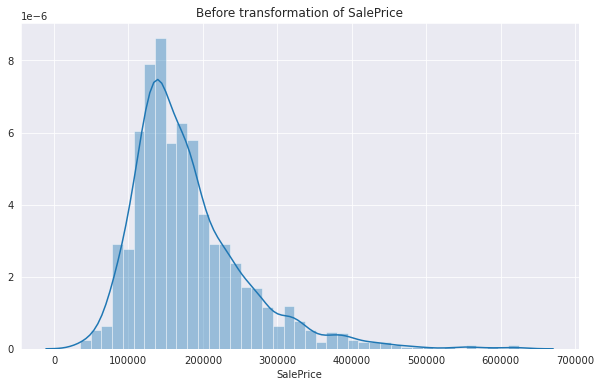

In [36]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'],norm_hist=False)

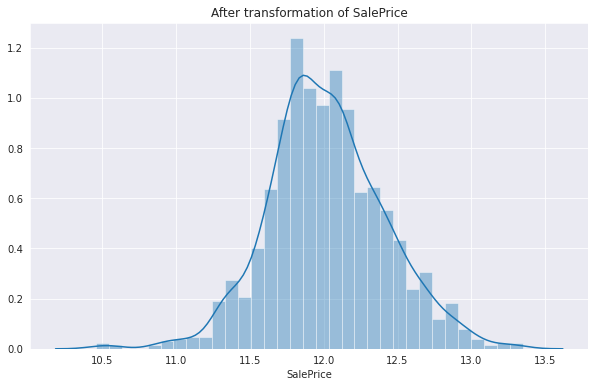

In [37]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [38]:
y = np.log(y)

In [39]:
x = X.loc[train.index]
y = y.loc[train.index]
test = X.loc[test.index]

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2020)

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

In [42]:
gbr = ensemble.GradientBoostingRegressor(learning_rate=0.02, n_estimators=2000,
                                           max_depth=5, min_samples_split=2,
                                           loss='ls', max_features=35)

xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7, reg_alpha = 0.0001,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=27)

lgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         reg_alpha = 0.0001,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                                       )

cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [43]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, x, y)


gbr.fit(X_train, y_train)   
preds = gbr.predict(X_val) 
preds_test_gbr = gbr.predict(test)
mae_gbr = mean_absolute_error(y_val, preds)
rmse_gbr = np.sqrt(mean_squared_error(y_val, preds))
score_gbr = gbr.score(X_val, y_val)
cv_gbr = mean_cross_val(gbr, x, y)


xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, x, y)


lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, x, y)

In [44]:
model_performances = pd.DataFrame({
    "Model" : ["Gradient Boosting Regression", "XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_gbr)[0:5], str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_gbr)[0:5], str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_gbr)[0:5], str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_gbr)[0:5], str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
                          Model  CV(5)    MAE   RMSE  Score
1                       XGBoost  0.917  0.073  0.103  0.928
3                      CatBoost  0.917  0.072  0.104  0.927
0  Gradient Boosting Regression  0.915  0.075  0.107  0.922
2                          LGBM  0.915  0.076  0.107  0.922


In [45]:
def blend_models_predict(X, a, b, c, d):
    return ((a * gbr.predict(X)) +  (b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

In [46]:
subm = np.exp(blend_models_predict(test, 0.6, 0.2, 0.2, 0))
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': subm})

submission.to_csv("../../kaggle/working/submission.csv", index=False)